In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
)

from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

def print_report_no_avgs(y_true, y_pred, name):
    rep = classification_report(y_true, y_pred, digits=4, output_dict=True)
    cls_0 = rep["0"]
    cls_1 = rep["1"]
    print(f"\nClassification report ({name}):")
    print("class  precision  recall  f1-score  support")
    print(
        f"0      {cls_0['precision']:.4f}   {cls_0['recall']:.4f}   "
        f"{cls_0['f1-score']:.4f}   {int(cls_0['support'])}"
    )
    print(
        f"1      {cls_1['precision']:.4f}   {cls_1['recall']:.4f}   "
        f"{cls_1['f1-score']:.4f}   {int(cls_1['support'])}"
    )


In [2]:
df = pd.read_csv("final_dataset.csv")
print("Data shape:", df.shape)

# features
df["debt_service_ratio"] = df["monthly_payment"] / (df["monthly_income"] + 1e-6)
df["available_credit_ratio"] = df["available_credit"] / (
    df["available_credit"] + df["loan_amount"] + 1e-6
)
df["interest_burden"] = (
    df["interest_rate"] * df["loan_amount"] / (df["monthly_income"] + 1e-6)
)

def age_to_category(age):
    if age < 25:
        return "<25"
    elif age < 35:
        return "25-35"
    elif age < 50:
        return "35-50"
    else:
        return "50+"

df["age_category"] = df["age"].apply(age_to_category)


Data shape: (89999, 51)


In [10]:
num_features = [
    "monthly_income",
    "employment_length",
    "monthly_payment",
    "payment_to_income_ratio",
    "credit_utilization",
    "available_credit",
    "loan_amount",
    "loan_term",
    "interest_rate",
    "num_delinquencies_2yrs",
    "age",
    "debt_service_ratio",
    "available_credit_ratio",
    "interest_burden",
]
cat_features = [
    "loan_purpose",
    "employment_type",
    "education",
    "marital_status",
    "age_category",
]
X = df[num_features + cat_features].copy()
y = df["default"].copy()
print(f"Feature matrix: {X.shape}")
print(f"Default rate: {y.mean()*100:.2f}%")

#Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

#Preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)
X_train_pre = preprocess.fit_transform(X_train)
X_test_pre = preprocess.transform(X_test)

#SMOTE
smote = SMOTE(random_state=42, sampling_strategy=0.2)
X_train_res, y_train_res = smote.fit_resample(X_train_pre, y_train)

pos_ratio = y_train_res.mean()
neg_ratio = 1 - pos_ratio
scale_pos_weight = neg_ratio / pos_ratio

print("After SMOTE:", X_train_res.shape, "pos_ratio:", pos_ratio)


Feature matrix: (89999, 19)
Default rate: 5.10%
Train: (62999, 19), Test: (27000, 19)
After SMOTE: (71739, 38) pos_ratio: 0.16665969695702476


In [11]:
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=600,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight={0: 1.0, 1: scale_pos_weight},
        n_jobs=-1,
        random_state=42,
    ),
    "XGBoost": XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="binary:logistic",
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight,
        reg_lambda=2.0,
        random_state=42,
        n_jobs=-1,
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=900,
        learning_rate=0.03,
        num_leaves=31,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_samples=50,
        class_weight={0: 1.0, 1: scale_pos_weight},
        reg_lambda=3.0,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    ),
}
#Train
results = {}
probas = {}
print("\nTraining models\n")

for name, clf in models.items():
    print(f"{name}...")
    clf.fit(X_train_res, y_train_res)

    y_proba = clf.predict_proba(X_test_pre)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results[name] = {"accuracy": acc, "auc": auc}
    probas[name] = y_proba

    print_report_no_avgs(y_test, y_pred, name)
    print(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}\n")

res_df = pd.DataFrame(results).T
print("Summary (threshold=0.5):")
print(res_df)


Training models

RandomForest...

Classification report (RandomForest):
class  precision  recall  f1-score  support
0      0.9593   0.9613   0.9603   25622
1      0.2513   0.2417   0.2464   1378
Accuracy: 0.9246, AUC: 0.7763

XGBoost...

Classification report (XGBoost):
class  precision  recall  f1-score  support
0      0.9659   0.9154   0.9400   25622
1      0.2026   0.3999   0.2690   1378
Accuracy: 0.8891, AUC: 0.7800

LightGBM...

Classification report (LightGBM):
class  precision  recall  f1-score  support
0      0.9630   0.9424   0.9526   25622
1      0.2342   0.3273   0.2730   1378
Accuracy: 0.9110, AUC: 0.7780

Summary (threshold=0.5):
              accuracy       auc
RandomForest  0.924556  0.776328
XGBoost       0.889074  0.779950
LightGBM      0.911037  0.777956



Best model by AUC: XGBoost (AUC=0.7800)

Best threshold: 0.54

Classification report (XGBoost (best threshold)):
class  precision  recall  f1-score  support
0      0.9641   0.9319   0.9477   25622
1      0.2185   0.3541   0.2703   1378


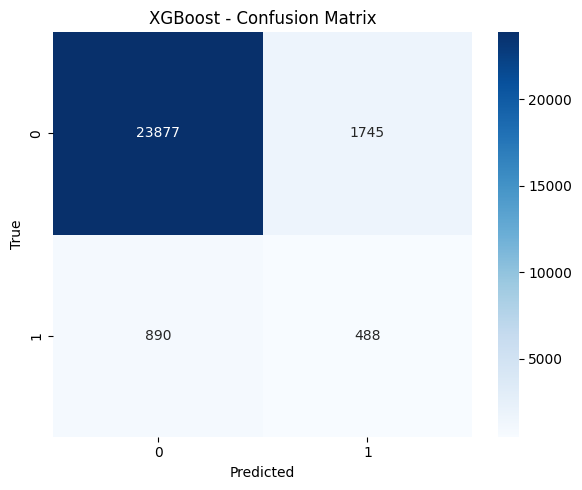

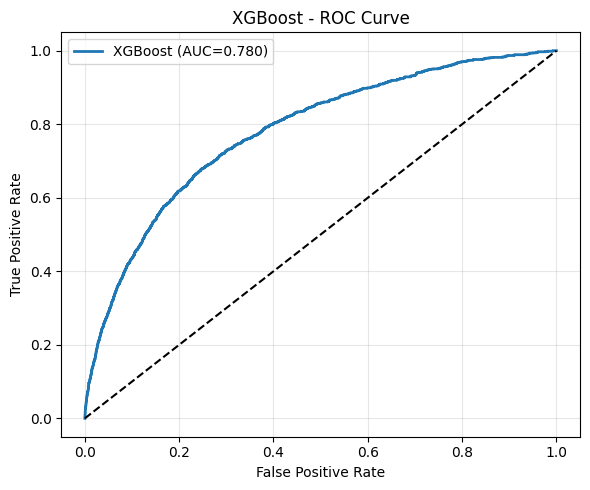

In [12]:
best_model_name = res_df["auc"].idxmax()
best_model = models[best_model_name]
best_proba = probas[best_model_name]
base_auc = res_df.loc[best_model_name, "auc"]
print(f"\nBest model by AUC: {best_model_name} (AUC={base_auc:.4f})")

thresholds = np.linspace(0.05, 0.95, 91)
best_th, best_f1, best_rec, best_prec = 0.5, 0, 0, 0

for th in thresholds:
    y_pred = (best_proba >= th).astype(int)
    prec_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)

    if (f1_1 > best_f1) or (f1_1 == best_f1 and rec_1 > best_rec):
        best_f1 = f1_1
        best_rec = rec_1
        best_prec = prec_1
        best_th = th

y_pred_best = (best_proba >= best_th).astype(int)
print(f"\nBest threshold: {best_th:.2f}")
print_report_no_avgs(y_test, y_pred_best, f"{best_model_name} (best threshold)")

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["0", "1"],
    yticklabels=["0", "1"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"{best_model_name} - Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

fpr, tpr, _ = roc_curve(y_test, best_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"{best_model_name} (AUC={base_auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"{best_model_name} - ROC Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=300)
plt.show()


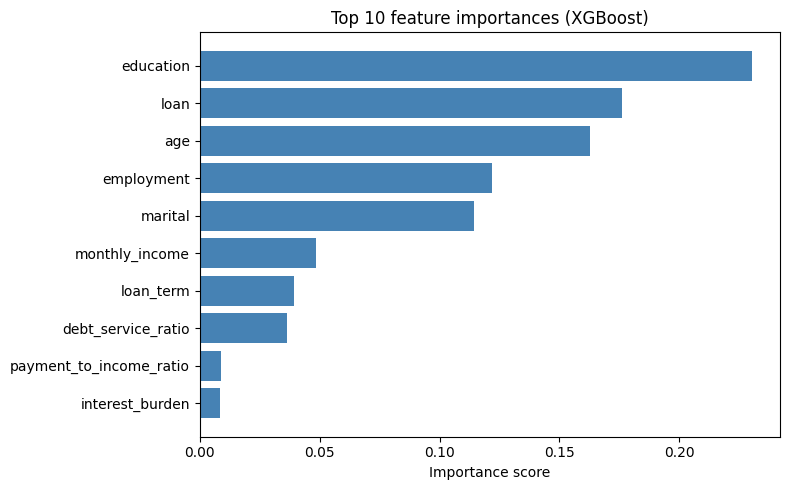

In [21]:
importances = best_model.feature_importances_

num_feature_names = num_features
cat_ohe_names = list(
    preprocess.named_transformers_["cat"].get_feature_names_out(cat_features)
)
all_feature_names = num_feature_names + cat_ohe_names
base_names = []
for name in all_feature_names:
    if name in num_feature_names:
        base_names.append(name)
    else:
        base_feat = name.split("_", 1)[0] 
        base_names.append(base_feat)

agg = {}
for bname, imp in zip(base_names, importances):
    agg[bname] = agg.get(bname, 0.0) + imp

agg_df = (
    pd.DataFrame({"feature": list(agg.keys()), "importance": list(agg.values())})
    .sort_values("importance", ascending=False)
)

top_k = 10
top_imp = agg_df.head(top_k)

plt.figure(figsize=(8, 5))
plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1], color="steelblue")
plt.xlabel("Importance score")
plt.title(f"Top {top_k} feature importances ({best_model_name})")
plt.tight_layout()
plt.savefig("feature_importances_aggregated.png", dpi=300)
plt.show()


In [22]:
joblib.dump(best_model, "best_model_xgb.pkl")
joblib.dump(preprocess, "preprocessor.pkl")
print("\nModels are saved as best_model_xgb.pkl and preprocessor.pkl")


Models are saved as best_model_xgb.pkl and preprocessor.pkl
